# I. Hướng dẫn

## Khởi tạo Spark

In [1]:
import findspark
findspark.init()

import pyspark
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import count

spark = (SparkSession
         .builder
         .appName("Clustering")
         .getOrCreate())

## Đọc và load tập dữ liệu Iris

In [2]:
irisDF = (spark.read
          .option("HEADER", True)
          .option("inferSchema", True)
          .csv("iris.csv")
         )

irisDF.show()

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9|        3.1|         1.5|        0.1|Iris-setosa|
|         5.4|        3.7|         1.5|        0.2|Iris-setosa|
|         4.8|        3.4|         1.6|        0.2|Iris-setosa|
|         4.8|        3.0|         1.4| 

## Tập dữ liệu Iris

`sepal_length`: chiều dài đài hoa (cm)

`sepal_width`: chiều rộng đài hoa (cm)

`petal_length`: chiều dài cánh hoa (cm)

`petal_width`: chiều rộng cánh hoa (cm)

`class/label`: loại hoa

## Xem các loại biến trong tập dữ liệu

In [3]:
irisDF.dtypes

[('sepal_length', 'double'),
 ('sepal_width', 'double'),
 ('petal_length', 'double'),
 ('petal_width', 'double'),
 ('class', 'string')]

## Chuyển cột `class` (kiểu string) thành `label` (kiểu double)

In [4]:
from pyspark.ml.feature import StringIndexer

class_indexer = StringIndexer(inputCol='class',outputCol='label')

print(class_indexer.fit(irisDF))

irisDFindexed = class_indexer.fit(irisDF).transform(irisDF)

irisDFindexed.show()

StringIndexerModel: uid=StringIndexer_d1e015e7032c, handleInvalid=error
+------------+-----------+------------+-----------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width|      class|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|  0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|  0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|  0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.1|         1.5|        0.1|Iris-setosa|  0.0|
|         5.4|    

In [5]:
irisDFindexed.select("label","class").distinct().show()

+-----+---------------+
|label|          class|
+-----+---------------+
|  0.0|    Iris-setosa|
|  1.0|Iris-versicolor|
|  2.0| Iris-virginica|
+-----+---------------+



## Biến đổi data theo định dạng của Spark

In [6]:
from pyspark.ml.feature import VectorAssembler


#vecAssembler = VectorAssembler(inputCols=['sepal_length','sepal_width','petal_length','petal_width'],
#                            outputCol='features')
#irisAssembler = vecAssembler.transform(irisDFindexed)

irisAssembler = (VectorAssembler(inputCols = ['sepal_length', 'sepal_width','petal_length','petal_width'], 
                                  outputCol = 'features')
                .transform(irisDFindexed))

irisFeaturesDF = irisAssembler.select('features')
irisFeaturesDF.show(10)

+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
|[4.6,3.4,1.4,0.3]|
|[5.0,3.4,1.5,0.2]|
|[4.4,2.9,1.4,0.2]|
|[4.9,3.1,1.5,0.1]|
+-----------------+
only showing top 10 rows



In [7]:
irisFeaturesDF.dtypes

[('features', 'vector')]

## Sử dụng thuật toán gom cụm Kmeans

**1.1** Áp dụng thuật toán `KMeans` trên `irisFeaturesDF` với `k = 3`, `maxIter = 20`

In [8]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, seed=1, maxIter=20)

#  Call fit on the estimator and pass in irisFeaturesDF
model = kmeans.fit(irisFeaturesDF)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedDF = model.transform(irisFeaturesDF)

print(centers)

transformedDF.show(100,False)

[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
+-----------------+----------+
|features         |prediction|
+-----------------+----------+
|[5.1,3.5,1.4,0.2]|1         |
|[4.9,3.0,1.4,0.2]|1         |
|[4.7,3.2,1.3,0.2]|1         |
|[4.6,3.1,1.5,0.2]|1         |
|[5.0,3.6,1.4,0.2]|1         |
|[5.4,3.9,1.7,0.4]|1         |
|[4.6,3.4,1.4,0.3]|1         |
|[5.0,3.4,1.5,0.2]|1         |
|[4.4,2.9,1.4,0.2]|1         |
|[4.9,3.1,1.5,0.1]|1         |
|[5.4,3.7,1.5,0.2]|1         |
|[4.8,3.4,1.6,0.2]|1         |
|[4.8,3.0,1.4,0.1]|1         |
|[4.3,3.0,1.1,0.1]|1         |
|[5.8,4.0,1.2,0.2]|1         |
|[5.7,4.4,1.5,0.4]|1         |
|[5.4,3.9,1.3,0.4]|1         |
|[5.1,3.5,1.4,0.3]|1         |
|[5.7,3.8,1.7,0.3]|1         |
|[5.1,3.8,1.5,0.3]|1         |
|[5.4,3.4,1.7,0.2]|1         |
|[5.1,3.7,1.5,0.4]|1         |
|[4.6,3.6,1.0,0.2]|1         |
|[5.1,3.3,1.7,0.5]|1         |
|[4.8,3.4,1

**1.2.** Tính giá trị `silhouette` của kết quả gom cụm

In [9]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(metricName="silhouette")

silhouette = evaluator.evaluate(transformedDF)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7354567373091194


**1.3.** Áp dụng thuật toán `KMeans` trên `irisFeaturesDF` với `k = 3`, và `maxIter` thay đổi

In [10]:
modelCenters = []
silhouetteModel = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=1, maxIter=i)
    model = kmeans.fit(irisFeaturesDF)
    modelCenters.append(model.clusterCenters())
    
    sillhouette = evaluator.evaluate(transformedDF)
    silhouetteModel.append(sillhouette)

In ra các centroid

In [11]:
print("modelCenters:")
for centroids in modelCenters:
  print(centroids)


print("silhouettes:")
for silhouette in silhouetteModel:
  print(silhouette)

modelCenters:
[array([5.94328358, 2.72835821, 4.4119403 , 1.46865672]), array([4.98 , 3.304, 1.462, 0.22 ]), array([6.86969697, 3.18787879, 5.76060606, 2.21212121])]
[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
silhouettes:
0.7354567373091194
0.7354567373091194
0.7354567373091194
0.73

# II. Áp dụng

## Câu 1 - Áp dụng `Kmeans` với tập dữ liệu `iris`

**1.1.** Tạo `features` column cho tập dữ liệu `iris` chỉ dùng 2 thuộc tính `sepal_length` và `sepal_width`.

In [12]:
# Viết code của bạn ở đây
irisDF2 = irisDF.select("sepal_length", "sepal_width")

irisAssembler = (VectorAssembler( inputCols = ["sepal_length", "sepal_width"],
                    outputCol = "features")
                    .transform(irisDF2))
irisFeaturesDF = irisAssembler.select('features')
irisFeaturesDF.show(10)

+---------+
| features|
+---------+
|[5.1,3.5]|
|[4.9,3.0]|
|[4.7,3.2]|
|[4.6,3.1]|
|[5.0,3.6]|
|[5.4,3.9]|
|[4.6,3.4]|
|[5.0,3.4]|
|[4.4,2.9]|
|[4.9,3.1]|
+---------+
only showing top 10 rows



**1.2.** Áp dụng `Kmeans` cho tập dữ liệu `iris` trên `features` vừa tạo với các giá trị siêu tham số `k = 3`, `seed=1`, và `maxIter=20`. Tham khảo document về `Kmeans` của Spark ở [Kmeans](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans).

In [13]:
# Viết code của bạn ở đây
kmeans = KMeans(k=3, seed=1, maxIter=20)

#  Call fit on the estimator and pass in irisFeaturesDF
model = kmeans.fit(irisFeaturesDF)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedDF = model.transform(irisFeaturesDF)

print(centers)

transformedDF.show(100,False)

[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
+---------+----------+
|features |prediction|
+---------+----------+
|[5.1,3.5]|1         |
|[4.9,3.0]|1         |
|[4.7,3.2]|1         |
|[4.6,3.1]|1         |
|[5.0,3.6]|1         |
|[5.4,3.9]|1         |
|[4.6,3.4]|1         |
|[5.0,3.4]|1         |
|[4.4,2.9]|1         |
|[4.9,3.1]|1         |
|[5.4,3.7]|1         |
|[4.8,3.4]|1         |
|[4.8,3.0]|1         |
|[4.3,3.0]|1         |
|[5.8,4.0]|1         |
|[5.7,4.4]|1         |
|[5.4,3.9]|1         |
|[5.1,3.5]|1         |
|[5.7,3.8]|1         |
|[5.1,3.8]|1         |
|[5.4,3.4]|1         |
|[5.1,3.7]|1         |
|[4.6,3.6]|1         |
|[5.1,3.3]|1         |
|[4.8,3.4]|1         |
|[5.0,3.0]|1         |
|[5.0,3.4]|1         |
|[5.2,3.5]|1         |
|[5.2,3.4]|1         |
|[4.7,3.2]|1         |
|[4.8,3.1]|1         |
|[5.4,3.4]|1         |
|[5.2,4.1]|1         |
|[5.5,4.2]|1         |
|[4.9,3.1]|1         |
|[5.0,3.2]|1         |
|[5.5,3.5]|1     

**1.2.** Tính giá trị `silhouette` của kết quả gom cụm

In [14]:
# Viết code của bạn ở đây
evaluator = ClusteringEvaluator(metricName="silhouette")

evaluator.evaluate(transformedDF)

0.6144693759745256

In [15]:
transformedDF.show()

+---------+----------+
| features|prediction|
+---------+----------+
|[5.1,3.5]|         1|
|[4.9,3.0]|         1|
|[4.7,3.2]|         1|
|[4.6,3.1]|         1|
|[5.0,3.6]|         1|
|[5.4,3.9]|         1|
|[4.6,3.4]|         1|
|[5.0,3.4]|         1|
|[4.4,2.9]|         1|
|[4.9,3.1]|         1|
|[5.4,3.7]|         1|
|[4.8,3.4]|         1|
|[4.8,3.0]|         1|
|[4.3,3.0]|         1|
|[5.8,4.0]|         1|
|[5.7,4.4]|         1|
|[5.4,3.9]|         1|
|[5.1,3.5]|         1|
|[5.7,3.8]|         1|
|[5.1,3.8]|         1|
+---------+----------+
only showing top 20 rows



**1.3.** Áp dụng thuật toán `KMeans` trên `features` đã tạo với `k = 3`, và `maxIter` thay đổi. In ra các centers và chỉ số `silhouette` cho từng kết quả gom cụm.

In [16]:
# Viết code của bạn ở đây
modelCenters = []
silhouetteModel = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=1, maxIter=i)
    model = kmeans.fit(irisFeaturesDF)
    modelCenters.append(model.clusterCenters())
    
    sillhouette = evaluator.evaluate(transformedDF)
    silhouetteModel.append(sillhouette)

In [17]:
print("modelCenters:")
for centroids in modelCenters:
  print(centroids)

modelCenters:
[array([5.74150943, 2.62075472]), array([5.57804878, 3.33780488]), array([7.47333333, 2.98      ])]
[array([5.87118644, 2.73389831]), array([5.01153846, 3.39230769]), array([6.91025641, 3.08717949])]
[array([5.84909091, 2.70909091]), array([5.00192308, 3.38076923]), array([6.85348837, 3.1       ])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]


In [18]:
print("silhouettes:")
for silhouette in silhouetteModel:
  print(silhouette)

silhouettes:
0.6144693759745256
0.6144693759745256
0.6144693759745256
0.6144693759745256
0.6144693759745256
0.6144693759745256


**1.4.** Trực quan hóa kết quả gom cụm dùng thư viện `matplotlib`. Tham khảo [python-machine-learning-book-3rd-edition-chapter11-notebook](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch11/ch11.ipynb).

Matplotlib is building the font cache; this may take a moment.
/home/giangvdq/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


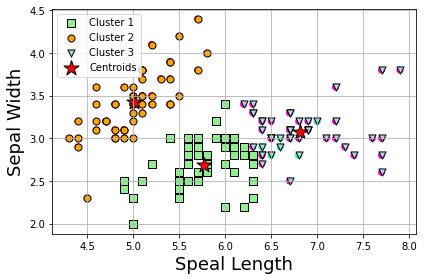

In [23]:
# Viết code của bạn ở đây
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target
plt.scatter(X[:,0], X[:,1], c=y, cmap='gist_rainbow')
plt.xlabel('Speal Length', fontsize=18)
plt.ylabel('Sepal Width', fontsize=18)


km = KMeans(n_clusters = 3, n_jobs = 4, random_state=21)


y_km = km.fit_predict(X)
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

## Câu 2 - Áp dụng `BisectingKMeans` trên tập dữ liệu `iris`

**Bisecting Kmeans** là một thuật toán gọm cụm thuộc nhóm **hierarchical clustering**. Khác với thuật toán **AGNES (agglomerative nesting)** tiếp cận theo hướng **bottom-up**, thuật toán **Bisecting Kmeans** tiếp cận theo hướng **top-down**.

**Ý tưởng của thuật toán Bisecting Kmeans**

Thuật toán khởi đầu bằng việc xem tất cả các điểm dữ liệu thuộc cùng một cụm và sau đó tiến hành như sau:

1. Chọn một cụm để tách
2. Tách cụm đã chọn thành 2 `sub-clusters` dùng thuật toán `K-means`. (`bisecting step`) 
3. Lặp lại bước 2 (`bisecting step`) `iter` lần và chọn ra phép tách tạo ra các cụm có `độ tương tự tổng thể` cao nhất.
4. Lặp lại bước 1, 2, và 3 cho đến khi đạt được số cụm mong muốn. 

- Có nhiều cách khác nhau để **chọn cụm để tách** (bước 1). Ta có thể chọn cụm có kích cỡ lớn nhất (nhiều phần tử nhất) ở mỗi bước, hoặc chọn cụm có độ tương tự tổng thể nhỏ nhất, hoặc chọn cụm dùng cả hai tiêu chí về kích cỡ và độ tương tự tổng thể.

- `Độ tương tự tổng thể` (`overall similarity`) của một cụm được tính bằng độ tương tự trung bình của các cặp phần tử trong cùng một cụm (`pairwise similarity`).

In [25]:
# Viết code của bạn ở đây

from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
model = bkm.fit(irisAssembler)

In [27]:
# Evaluate clustering.
cost = model.computeCost(irisAssembler)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 41.36153800650694


In [28]:
# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[5.5  2.65]
[5.01632653 3.44081633]
[6.58985507 2.96666667]


## Câu 3 - Áp dụng `GaussianMixture` trên tập dữ liệu `iris`

**Gaussian Mixture Model** là một trường hợp đặt biệt của [**Mixture Model**](https://en.wikipedia.org/wiki/Mixture_model). Mô hình hỗn hợp (mixture model) là một mô hình xác suất biểu diễn cho sự hiện diện của các nhóm con trong một tổng thể. Một mô hình hỗn hợp tương ứng với phân bố hỗn hợp (mixture distribution) biểu diễn phân phối xác suất của các phần tử trong một tổng thể.

Mixture model cũng thuộc lớp các `mô hình sinh` (`generative model`). `Mô hình sinh` dựa trên ý tưởng dữ liệu được sinh từ một mô hình ẩn bên dưới với các tham số. Ta cần tìm cách ước lượng các tham số sao cho nó cực đại hóa xác suất sinh ra dữ liệu. `Mô hình hỗn hợp Gauss` (`Gaussian mixture model`) giả định rằng dữ liệu được sinh từ một tổ hợp các phân bố Gauss. Ta cần ước lượng các tham số của mô hình, tức $\theta = \{(\mu_i, \sigma_i)\}_{i=1..k}$ (mỗi phân bố Gauss được biểu diễn bởi một cặp $(\mu_i, \sigma_i)$), sao cho xác xuất sinh ra tập dữ liệu $D = \{x_1, x_2, \cdots, x_n\}$, $P(D | \theta)$, là lớn nhất. Thuật toán `Expectation-Maximization` (`EM`) thường được sử dụng để ước lượng các tham số cho mô hình `Gaussian mixture model`. Tham khảo thêm [Gaussian mixture model](https://fallfordata.com/soft-clustering-with-gaussian-mixture-models-gmm/).

Khác với các thuật toán `gom cụm cứng` (`hard clustering`), Gaussian mixture model được xem là một thuật toán `gom cụm mềm` (`soft clustring`). Mỗi phần tử có thể thuộc nhiều cụm ứng với xác suất khác nhau.

In [32]:
# Viết code của bạn ở đây
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(3).setSeed(538009335)
model = gmm.fit(irisFeaturesDF)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show()

Gaussians shown as a DataFrame: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[6.05512780452505...|0.327557618491266...|
|[6.33126469977101...|0.517882974473787...|
|[5.01560927774038...|0.119415061646363...|
+--------------------+--------------------+

